In [1]:
!pip install gym['atari'] psutil pandas tensorflow==1.15 matplotlib

In [2]:
#git clone https://github.com/dennybritz/reinforcement-learning.git reinforcementlearning

In [3]:
%matplotlib inline

import gym
from gym.wrappers import Monitor
import itertools
import numpy as np
import os
import random
import sys
import psutil
import tensorflow as tf

from reinforcementlearning.lib import plotting
from collections import deque, namedtuple

In [4]:
env = gym.envs.make("Breakout-v0")

In [5]:
# Atari Actions: 0 (noop), 1 (fire), 2 (left) and 3 (right) are valid actions
VALID_ACTIONS = [0, 1, 2, 3]

In [6]:
class StateProcessor():
    """
    Processes a raw Atari images. Resizes it and converts it to grayscale.
    """
    def __init__(self):
        # Build the Tensorflow graph
        with tf.variable_scope("state_processor"):
            self.input_state = tf.placeholder(shape=[210, 160, 3], dtype=tf.uint8)
            self.output = tf.image.rgb_to_grayscale(self.input_state)
            self.output = tf.image.crop_to_bounding_box(self.output, 34, 0, 160, 160)
            self.output = tf.image.resize_images(
                self.output, [84, 84], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
            self.output = tf.squeeze(self.output)

    def process(self, sess, state):
        """
        Args:
            sess: A Tensorflow session object
            state: A [210, 160, 3] Atari RGB State

        Returns:
            A processed [84, 84] state representing grayscale values.
        """
        return sess.run(self.output, { self.input_state: state })

In [7]:
class Estimator():
    """Q-Value Estimator neural network.

    This network is used for both the Q-Network and the Target Network.
    """

    def __init__(self, scope="estimator", summaries_dir=None):
        self.scope = scope
        # Writes Tensorboard summaries to disk
        self.summary_writer = None
        with tf.variable_scope(scope):
            # Build the graph
            self._build_model()
            if summaries_dir:
                summary_dir = os.path.join(summaries_dir, "summaries_{}".format(scope))
                if not os.path.exists(summary_dir):
                    os.makedirs(summary_dir)
                self.summary_writer = tf.summary.FileWriter(summary_dir)

    def _build_model(self):
        """
        Builds the Tensorflow graph.
        """

        # Placeholders for our input
        # Our input are 4 grayscale frames of shape 84, 84 each
        self.X_pl = tf.placeholder(shape=[None, 84, 84, 4], dtype=tf.uint8, name="X")
        # The TD target value
        self.y_pl = tf.placeholder(shape=[None], dtype=tf.float32, name="y")
        # Integer id of which action was selected
        self.actions_pl = tf.placeholder(shape=[None], dtype=tf.int32, name="actions")

        X = tf.to_float(self.X_pl) / 255.0
        batch_size = tf.shape(self.X_pl)[0]

        # Three convolutional layers
        conv1 = tf.contrib.layers.conv2d(
            X, 32, 8, 4, activation_fn=tf.nn.relu)
        conv2 = tf.contrib.layers.conv2d(
            conv1, 64, 4, 2, activation_fn=tf.nn.relu)
        conv3 = tf.contrib.layers.conv2d(
            conv2, 64, 3, 1, activation_fn=tf.nn.relu)

        # Fully connected layers
        flattened = tf.contrib.layers.flatten(conv3)
        fc1 = tf.contrib.layers.fully_connected(flattened, 512)
        self.predictions = tf.contrib.layers.fully_connected(fc1, len(VALID_ACTIONS))

        # Get the predictions for the chosen actions only
        gather_indices = tf.range(batch_size) * tf.shape(self.predictions)[1] + self.actions_pl
        self.action_predictions = tf.gather(tf.reshape(self.predictions, [-1]), gather_indices)

        # Calculate the loss
        self.losses = tf.squared_difference(self.y_pl, self.action_predictions)
        self.loss = tf.reduce_mean(self.losses)

        # Optimizer Parameters from original paper
        self.optimizer = tf.train.RMSPropOptimizer(0.00025, 0.99, 0.0, 1e-6)
        self.train_op = self.optimizer.minimize(self.loss, global_step=tf.contrib.framework.get_global_step())

        # Summaries for Tensorboard
        self.summaries = tf.summary.merge([
            tf.summary.scalar("loss", self.loss),
            tf.summary.histogram("loss_hist", self.losses),
            tf.summary.histogram("q_values_hist", self.predictions),
            tf.summary.scalar("max_q_value", tf.reduce_max(self.predictions))
        ])

    def predict(self, sess, s):
        """
        Predicts action values.

        Args:
          sess: Tensorflow session
          s: State input of shape [batch_size, 4, 84, 84, 1]

        Returns:
          Tensor of shape [batch_size, NUM_VALID_ACTIONS] containing the estimated 
          action values.
        """
        return sess.run(self.predictions, { self.X_pl: s })

    def update(self, sess, s, a, y):
        """
        Updates the estimator towards the given targets.

        Args:
          sess: Tensorflow session object
          s: State input of shape [batch_size, 4, 84, 84, 1]
          a: Chosen actions of shape [batch_size]
          y: Targets of shape [batch_size]

        Returns:
          The calculated loss on the batch.
        """
        feed_dict = { self.X_pl: s, self.y_pl: y, self.actions_pl: a }
        summaries, global_step, _, loss = sess.run(
            [self.summaries, tf.contrib.framework.get_global_step(), self.train_op, self.loss],
            feed_dict)
        if self.summary_writer:
            self.summary_writer.add_summary(summaries, global_step)
        return loss

In [8]:
# For Testing....

tf.reset_default_graph()
global_step = tf.Variable(0, name="global_step", trainable=False)

e = Estimator(scope="test")
sp = StateProcessor()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    # Example observation batch
    observation = env.reset()
    
    observation_p = sp.process(sess, observation)
    observation = np.stack([observation_p] * 4, axis=2)
    observations = np.array([observation] * 2)
    
    # Test Prediction
    print(e.predict(sess, observations))

    # Test training step
    y = np.array([10.0, 10.0])
    a = np.array([1, 3])
    print(e.update(sess, observations, a, y))

Instructions for updating:
Use `tf.cast` instead.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Please switch to tf.train.get_global_step
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
[[0.         0.01247877 0.         0.        ]
 [0.         0.01247877 0.         0.        ]]
99.87529


In [9]:
class ModelParametersCopier():
    """
    Copy model parameters of one estimator to another.
    """
    
    def __init__(self, estimator1, estimator2):
        """
        Defines copy-work operation graph.  
        Args:
          estimator1: Estimator to copy the paramters from
          estimator2: Estimator to copy the parameters to
        """
        e1_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator1.scope)]
        e1_params = sorted(e1_params, key=lambda v: v.name)
        e2_params = [t for t in tf.trainable_variables() if t.name.startswith(estimator2.scope)]
        e2_params = sorted(e2_params, key=lambda v: v.name)

        self.update_ops = []
        for e1_v, e2_v in zip(e1_params, e2_params):
            op = e2_v.assign(e1_v)
            self.update_ops.append(op)
            
    def make(self, sess):
        """
        Makes copy.
        Args:
            sess: Tensorflow session instance
        """
        sess.run(self.update_ops)

In [10]:
def make_epsilon_greedy_policy(estimator, nA):
    """
    Creates an epsilon-greedy policy based on a given Q-function approximator and epsilon.

    Args:
        estimator: An estimator that returns q values for a given state
        nA: Number of actions in the environment.

    Returns:
        A function that takes the (sess, observation, epsilon) as an argument and returns
        the probabilities for each action in the form of a numpy array of length nA.

    """
    def policy_fn(sess, observation, epsilon):
        A = np.ones(nA, dtype=float) * epsilon / nA
        q_values = estimator.predict(sess, np.expand_dims(observation, 0))[0]
        best_action = np.argmax(q_values)
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [11]:
def deep_q_learning(sess,
                    env,
                    q_estimator,
                    target_estimator,
                    state_processor,
                    num_episodes,
                    experiment_dir,
                    replay_memory_size=500000,
                    replay_memory_init_size=50000,
                    update_target_estimator_every=10000,
                    discount_factor=0.99,
                    epsilon_start=1.0,
                    epsilon_end=0.1,
                    epsilon_decay_steps=500000,
                    batch_size=32,
                    record_video_every=50):
    """
    Q-Learning algorithm for off-policy TD control using Function Approximation.
    Finds the optimal greedy policy while following an epsilon-greedy policy.

    Args:
        sess: Tensorflow Session object
        env: OpenAI environment
        q_estimator: Estimator object used for the q values
        target_estimator: Estimator object used for the targets
        state_processor: A StateProcessor object
        num_episodes: Number of episodes to run for
        experiment_dir: Directory to save Tensorflow summaries in
        replay_memory_size: Size of the replay memory
        replay_memory_init_size: Number of random experiences to sampel when initializing 
          the reply memory.
        update_target_estimator_every: Copy parameters from the Q estimator to the 
          target estimator every N steps
        discount_factor: Gamma discount factor
        epsilon_start: Chance to sample a random action when taking an action.
          Epsilon is decayed over time and this is the start value
        epsilon_end: The final minimum value of epsilon after decaying is done
        epsilon_decay_steps: Number of steps to decay epsilon over
        batch_size: Size of batches to sample from the replay memory
        record_video_every: Record a video every N episodes

    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    Transition = namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])

    # The replay memory
    replay_memory = []
    
    # Make model copier object
    estimator_copy = ModelParametersCopier(q_estimator, target_estimator)

    # Keeps track of useful statistics
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))
    
    # For 'system/' summaries, usefull to check if currrent process looks healthy
    current_process = psutil.Process()

    # Create directories for checkpoints and summaries
    checkpoint_dir = os.path.join(experiment_dir, "checkpoints")
    checkpoint_path = os.path.join(checkpoint_dir, "model")
    monitor_path = os.path.join(experiment_dir, "monitor")
    
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    if not os.path.exists(monitor_path):
        os.makedirs(monitor_path)

    saver = tf.train.Saver()
    # Load a previous checkpoint if we find one
    latest_checkpoint = tf.train.latest_checkpoint(checkpoint_dir)
    if latest_checkpoint:
        print("Loading model checkpoint {}...\n".format(latest_checkpoint))
        saver.restore(sess, latest_checkpoint)
    
    # Get the current time step
    total_t = sess.run(tf.contrib.framework.get_global_step())

    # The epsilon decay schedule
    epsilons = np.linspace(epsilon_start, epsilon_end, epsilon_decay_steps)

    # The policy we're following
    policy = make_epsilon_greedy_policy(
        q_estimator,
        len(VALID_ACTIONS))

    # Populate the replay memory with initial experience
    print("Populating replay memory...")
    state = env.reset()
    state = state_processor.process(sess, state)
    state = np.stack([state] * 4, axis=2)
    for i in range(replay_memory_init_size):
        action_probs = policy(sess, state, epsilons[min(total_t, epsilon_decay_steps-1)])
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
        next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
        next_state = state_processor.process(sess, next_state)
        next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)
        replay_memory.append(Transition(state, action, reward, next_state, done))
        if done:
            state = env.reset()
            state = state_processor.process(sess, state)
            state = np.stack([state] * 4, axis=2)
        else:
            state = next_state

    for i_episode in range(num_episodes):

        # Save the current checkpoint
        saver.save(tf.get_default_session(), checkpoint_path)

        # Reset the environment
        state = env.reset()
        state = state_processor.process(sess, state)
        state = np.stack([state] * 4, axis=2)
        loss = None

        # One step in the environment
        for t in itertools.count():

            # Epsilon for this time step
            epsilon = epsilons[min(total_t, epsilon_decay_steps-1)]

            # Maybe update the target estimator
            if total_t % update_target_estimator_every == 0:
                estimator_copy.make(sess)
                print("\nCopied model parameters to target network.")

            # Print out which step we're on, useful for debugging.
            print("\rStep {} ({}) @ Episode {}/{}, loss: {}".format(
                    t, total_t, i_episode + 1, num_episodes, loss), end="")
            sys.stdout.flush()

            # Take a step
            action_probs = policy(sess, state, epsilon)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(VALID_ACTIONS[action])
            next_state = state_processor.process(sess, next_state)
            next_state = np.append(state[:,:,1:], np.expand_dims(next_state, 2), axis=2)

            # If our replay memory is full, pop the first element
            if len(replay_memory) == replay_memory_size:
                replay_memory.pop(0)

            # Save transition to replay memory
            replay_memory.append(Transition(state, action, reward, next_state, done))   

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t

            # Sample a minibatch from the replay memory
            samples = random.sample(replay_memory, batch_size)
            states_batch, action_batch, reward_batch, next_states_batch, done_batch = map(np.array, zip(*samples))

            # Calculate q values and targets
            q_values_next = target_estimator.predict(sess, next_states_batch)
            targets_batch = reward_batch + np.invert(done_batch).astype(np.float32) * discount_factor * np.amax(q_values_next, axis=1)

            # Perform gradient descent update
            states_batch = np.array(states_batch)
            loss = q_estimator.update(sess, states_batch, action_batch, targets_batch)

            if done:
                break

            state = next_state
            total_t += 1

        # Add summaries to tensorboard
        episode_summary = tf.Summary()
        episode_summary.value.add(simple_value=epsilon, tag="episode/epsilon")
        episode_summary.value.add(simple_value=stats.episode_rewards[i_episode], tag="episode/reward")
        episode_summary.value.add(simple_value=stats.episode_lengths[i_episode], tag="episode/length")
        episode_summary.value.add(simple_value=current_process.cpu_percent(), tag="system/cpu_usage_percent")
        episode_summary.value.add(simple_value=current_process.memory_percent(memtype="vms"), tag="system/v_memeory_usage_percent")
        q_estimator.summary_writer.add_summary(episode_summary, i_episode)
        q_estimator.summary_writer.flush()
        
        yield total_t, plotting.EpisodeStats(
            episode_lengths=stats.episode_lengths[:i_episode+1],
            episode_rewards=stats.episode_rewards[:i_episode+1])

    return stats

In [12]:
tf.reset_default_graph()

# Where we save our checkpoints and graphs
experiment_dir = os.path.abspath("./experiments222/{}".format(env.spec.id))

# Create a glboal step variable
global_step = tf.Variable(0, name='global_step', trainable=False)
    
# Create estimators
q_estimator = Estimator(scope="q_estimator", summaries_dir=experiment_dir)
target_estimator = Estimator(scope="target_q")

# State processor
state_processor = StateProcessor()

# Run it!
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    for t, stats in deep_q_learning(sess,
                                    env,
                                    q_estimator=q_estimator,
                                    target_estimator=target_estimator,
                                    state_processor=state_processor,
                                    experiment_dir=experiment_dir,
                                    num_episodes=10000,
                                    replay_memory_size=500000,
                                    replay_memory_init_size=200000,
                                    update_target_estimator_every=10000,
                                    epsilon_start=1.0,
                                    epsilon_end=0.1,
                                    epsilon_decay_steps=500000,
                                    discount_factor=0.99,
                                    batch_size=40):

        print("\nEpisode Reward: {}".format(stats.episode_rewards[-1]))

Populating replay memory...

Copied model parameters to target network.
Step 308 (308) @ Episode 1/10000, loss: 0.0015890973154455423
Episode Reward: 2.0
Step 246 (554) @ Episode 2/10000, loss: 0.0018672455335035929
Episode Reward: 1.0
Step 301 (855) @ Episode 3/10000, loss: 0.0019806427881121635
Episode Reward: 2.0
Step 206 (1061) @ Episode 4/10000, loss: 0.00114826927892863755
Episode Reward: 1.0
Step 176 (1237) @ Episode 5/10000, loss: 0.0258427560329437262
Episode Reward: 0.0
Step 270 (1507) @ Episode 6/10000, loss: 0.00126264814753085374
Episode Reward: 2.0
Step 236 (1743) @ Episode 7/10000, loss: 0.00149470590986311444
Episode Reward: 2.0
Step 357 (2100) @ Episode 8/10000, loss: 0.00052745128050446513
Episode Reward: 3.0
Step 230 (2330) @ Episode 9/10000, loss: 0.00129741232376545677
Episode Reward: 1.0
Step 167 (2497) @ Episode 10/10000, loss: 0.02602124586701393884
Episode Reward: 0.0
Step 308 (2805) @ Episode 11/10000, loss: 0.00058513542171567684
Episode Reward: 2.0
Step 232 

Step 273 (24673) @ Episode 94/10000, loss: 0.0505054406821727758
Episode Reward: 2.0
Step 390 (25063) @ Episode 95/10000, loss: 0.0012159936595708132
Episode Reward: 4.0
Step 163 (25226) @ Episode 96/10000, loss: 0.0010933714220300317
Episode Reward: 0.0
Step 168 (25394) @ Episode 97/10000, loss: 0.0011041678953915834
Episode Reward: 0.0
Step 386 (25780) @ Episode 98/10000, loss: 0.0254173092544078836
Episode Reward: 4.0
Step 175 (25955) @ Episode 99/10000, loss: 0.00141997006721794624
Episode Reward: 0.0
Step 342 (26297) @ Episode 100/10000, loss: 0.0017953620990738273
Episode Reward: 3.0
Step 229 (26526) @ Episode 101/10000, loss: 0.00162504648324102164
Episode Reward: 1.0
Step 257 (26783) @ Episode 102/10000, loss: 0.00131415040232241153
Episode Reward: 2.0
Step 313 (27096) @ Episode 103/10000, loss: 0.00180731713771820072
Episode Reward: 3.0
Step 244 (27340) @ Episode 104/10000, loss: 0.0015623240033164623
Episode Reward: 1.0
Step 166 (27506) @ Episode 105/10000, loss: 0.0009892999

Step 258 (47108) @ Episode 186/10000, loss: 6.106946239015087e-051
Episode Reward: 1.0
Step 211 (47319) @ Episode 187/10000, loss: 0.00023698885343037546
Episode Reward: 1.0
Step 166 (47485) @ Episode 188/10000, loss: 0.00088314182357862595
Episode Reward: 0.0
Step 214 (47699) @ Episode 189/10000, loss: 0.00034018440055660903
Episode Reward: 1.0
Step 233 (47932) @ Episode 190/10000, loss: 0.00011792851000791416
Episode Reward: 1.0
Step 170 (48102) @ Episode 191/10000, loss: 0.02325731329619884556
Episode Reward: 0.0
Step 175 (48277) @ Episode 192/10000, loss: 0.00024776239297352732
Episode Reward: 0.0
Step 163 (48440) @ Episode 193/10000, loss: 0.00017459562513977294
Episode Reward: 0.0
Step 179 (48619) @ Episode 194/10000, loss: 0.00044414680451154715
Episode Reward: 0.0
Step 266 (48885) @ Episode 195/10000, loss: 0.00012275518383830786
Episode Reward: 2.0
Step 266 (49151) @ Episode 196/10000, loss: 0.00084773229900747545
Episode Reward: 2.0
Step 364 (49515) @ Episode 197/10000, loss:

Step 184 (67632) @ Episode 277/10000, loss: 0.00011965096928179264
Episode Reward: 0.0
Step 291 (67923) @ Episode 278/10000, loss: 0.00288941734470427048
Episode Reward: 2.0
Step 381 (68304) @ Episode 279/10000, loss: 0.00286263623274862772
Episode Reward: 3.0
Step 179 (68483) @ Episode 280/10000, loss: 0.00068837136495858435
Episode Reward: 0.0
Step 238 (68721) @ Episode 281/10000, loss: 3.0414597858907655e-05
Episode Reward: 1.0
Step 170 (68891) @ Episode 282/10000, loss: 0.00020745699293911457
Episode Reward: 0.0
Step 218 (69109) @ Episode 283/10000, loss: 0.00259324093349277973
Episode Reward: 1.0
Step 207 (69316) @ Episode 284/10000, loss: 0.00110567011870443824
Episode Reward: 1.0
Step 251 (69567) @ Episode 285/10000, loss: 3.198799822712317e-058
Episode Reward: 2.0
Step 211 (69778) @ Episode 286/10000, loss: 0.00145843334030359986
Episode Reward: 1.0
Step 221 (69999) @ Episode 287/10000, loss: 9.081087046070024e-055
Copied model parameters to target network.
Step 230 (70008) @ E

Step 232 (90425) @ Episode 367/10000, loss: 0.00034529596450738618
Episode Reward: 1.0
Step 526 (90951) @ Episode 368/10000, loss: 0.00038405362283810973
Episode Reward: 6.0
Step 309 (91260) @ Episode 369/10000, loss: 0.00050194805953651677
Episode Reward: 2.0
Step 303 (91563) @ Episode 370/10000, loss: 0.00030819297535344966
Episode Reward: 2.0
Step 272 (91835) @ Episode 371/10000, loss: 7.394158456008881e-054
Episode Reward: 2.0
Step 282 (92117) @ Episode 372/10000, loss: 0.00223304471001029555
Episode Reward: 2.0
Step 214 (92331) @ Episode 373/10000, loss: 0.00272705731913447482
Episode Reward: 1.0
Step 171 (92502) @ Episode 374/10000, loss: 0.00036263084621168673
Episode Reward: 0.0
Step 241 (92743) @ Episode 375/10000, loss: 0.00197019102051854134
Episode Reward: 1.0
Step 182 (92925) @ Episode 376/10000, loss: 1.912010156956967e-057
Episode Reward: 0.0
Step 323 (93248) @ Episode 377/10000, loss: 0.00019584600522648543
Episode Reward: 2.0
Step 338 (93586) @ Episode 378/10000, loss:

Step 291 (113210) @ Episode 458/10000, loss: 0.00036336618359200656
Episode Reward: 2.0
Step 188 (113398) @ Episode 459/10000, loss: 0.00016514760500285774
Episode Reward: 0.0
Step 212 (113610) @ Episode 460/10000, loss: 0.00014856259804219007
Episode Reward: 1.0
Step 218 (113828) @ Episode 461/10000, loss: 0.00082039786502718934
Episode Reward: 1.0
Step 173 (114001) @ Episode 462/10000, loss: 6.655659672105685e-055
Episode Reward: 0.0
Step 246 (114247) @ Episode 463/10000, loss: 0.00048106210306286817
Episode Reward: 1.0
Step 199 (114446) @ Episode 464/10000, loss: 0.00101850787177681925
Episode Reward: 0.0
Step 359 (114805) @ Episode 465/10000, loss: 0.00033421648549847305
Episode Reward: 3.0
Step 273 (115078) @ Episode 466/10000, loss: 0.00035226615727879107
Episode Reward: 2.0
Step 242 (115320) @ Episode 467/10000, loss: 6.328726158244535e-055
Episode Reward: 1.0
Step 325 (115645) @ Episode 468/10000, loss: 0.00046840793220326304
Episode Reward: 3.0
Step 232 (115877) @ Episode 469/

Step 258 (135165) @ Episode 548/10000, loss: 0.00048930599587038163
Episode Reward: 2.0
Step 252 (135417) @ Episode 549/10000, loss: 0.00106747203972190628
Episode Reward: 1.0
Step 323 (135740) @ Episode 550/10000, loss: 0.00058026972692459826
Episode Reward: 3.0
Step 276 (136016) @ Episode 551/10000, loss: 0.00172581023070961246
Episode Reward: 2.0
Step 190 (136206) @ Episode 552/10000, loss: 0.00079639803152531396
Episode Reward: 0.0
Step 388 (136594) @ Episode 553/10000, loss: 0.00041873194277286537
Episode Reward: 4.0
Step 179 (136773) @ Episode 554/10000, loss: 0.00061787373851984745
Episode Reward: 0.0
Step 207 (136980) @ Episode 555/10000, loss: 0.00133306928910315047
Episode Reward: 1.0
Step 228 (137208) @ Episode 556/10000, loss: 0.00029589686891995376
Episode Reward: 1.0
Step 243 (137451) @ Episode 557/10000, loss: 0.00018133569392375648
Episode Reward: 2.0
Step 200 (137651) @ Episode 558/10000, loss: 0.00032839708728715782
Episode Reward: 1.0
Step 232 (137883) @ Episode 559/

Step 354 (157974) @ Episode 638/10000, loss: 0.00080013117985799916
Episode Reward: 3.0
Step 182 (158156) @ Episode 639/10000, loss: 0.00122923252638429426
Episode Reward: 0.0
Step 176 (158332) @ Episode 640/10000, loss: 0.00020776805467903614
Episode Reward: 0.0
Step 227 (158559) @ Episode 641/10000, loss: 0.00011565825116122141
Episode Reward: 1.0
Step 264 (158823) @ Episode 642/10000, loss: 0.00018443372391629964
Episode Reward: 2.0
Step 259 (159082) @ Episode 643/10000, loss: 0.00086925632786005744
Episode Reward: 2.0
Step 163 (159245) @ Episode 644/10000, loss: 0.00061974406708031893
Episode Reward: 0.0
Step 312 (159557) @ Episode 645/10000, loss: 0.00063117046374827625
Episode Reward: 2.0
Step 341 (159898) @ Episode 646/10000, loss: 0.00077612744644284257
Episode Reward: 3.0
Step 101 (159999) @ Episode 647/10000, loss: 0.00017478177323937416
Copied model parameters to target network.
Step 247 (160145) @ Episode 647/10000, loss: 0.00028195226332172759
Episode Reward: 2.0
Step 250 

Step 280 (181117) @ Episode 727/10000, loss: 0.00146670488175004723
Episode Reward: 2.0
Step 240 (181357) @ Episode 728/10000, loss: 0.00012152257841080427
Episode Reward: 1.0
Step 247 (181604) @ Episode 729/10000, loss: 0.00065366504713892943
Episode Reward: 2.0
Step 229 (181833) @ Episode 730/10000, loss: 0.00019082233484368776
Episode Reward: 1.0
Step 196 (182029) @ Episode 731/10000, loss: 0.00106534117367118698
Episode Reward: 0.0
Step 302 (182331) @ Episode 732/10000, loss: 0.00188610295299440625
Episode Reward: 2.0
Step 338 (182669) @ Episode 733/10000, loss: 0.00049874820979312065
Episode Reward: 3.0
Step 353 (183022) @ Episode 734/10000, loss: 0.00013594146003015345
Episode Reward: 3.0
Step 366 (183388) @ Episode 735/10000, loss: 0.00047712173545733094
Episode Reward: 3.0
Step 451 (183839) @ Episode 736/10000, loss: 0.00089655059855431327
Episode Reward: 5.0
Step 233 (184072) @ Episode 737/10000, loss: 0.00203472422435879787
Episode Reward: 1.0
Step 291 (184363) @ Episode 738/

Step 227 (203690) @ Episode 817/10000, loss: 9.76905575953424e-0524
Episode Reward: 1.0
Step 355 (204045) @ Episode 818/10000, loss: 6.629969720961526e-056
Episode Reward: 3.0
Step 170 (204215) @ Episode 819/10000, loss: 0.00015122847980819643
Episode Reward: 0.0
Step 330 (204545) @ Episode 820/10000, loss: 0.00020435401529539376
Episode Reward: 3.0
Step 165 (204710) @ Episode 821/10000, loss: 0.00040277597145177424
Episode Reward: 0.0
Step 229 (204939) @ Episode 822/10000, loss: 0.00051539496053010233
Episode Reward: 1.0
Step 258 (205197) @ Episode 823/10000, loss: 0.00034600231447257182
Episode Reward: 2.0
Step 438 (205635) @ Episode 824/10000, loss: 0.00015606934903189543
Episode Reward: 4.0
Step 241 (205876) @ Episode 825/10000, loss: 0.00047383038327097893
Episode Reward: 1.0
Step 191 (206067) @ Episode 826/10000, loss: 0.00031298593967221685
Episode Reward: 0.0
Step 165 (206232) @ Episode 827/10000, loss: 0.00011863505642395467
Episode Reward: 0.0
Step 180 (206412) @ Episode 828/

Step 185 (227466) @ Episode 907/10000, loss: 0.00011134927626699209
Episode Reward: 0.0
Step 199 (227665) @ Episode 908/10000, loss: 0.00068106176331639294
Episode Reward: 1.0
Step 385 (228050) @ Episode 909/10000, loss: 0.00093124306295067072
Episode Reward: 4.0
Step 304 (228354) @ Episode 910/10000, loss: 0.00064645957900211226
Episode Reward: 2.0
Step 168 (228522) @ Episode 911/10000, loss: 0.00012227927800267935
Episode Reward: 0.0
Step 236 (228758) @ Episode 912/10000, loss: 5.245232750894502e-057
Episode Reward: 1.0
Step 267 (229025) @ Episode 913/10000, loss: 0.00036675803130492578
Episode Reward: 2.0
Step 174 (229199) @ Episode 914/10000, loss: 0.00103423057589679962
Episode Reward: 0.0
Step 417 (229616) @ Episode 915/10000, loss: 0.00027992477407678964
Episode Reward: 4.0
Step 204 (229820) @ Episode 916/10000, loss: 0.00043287026346661158
Episode Reward: 1.0
Step 179 (229999) @ Episode 917/10000, loss: 7.971747254487127e-057
Copied model parameters to target network.
Step 249 

Step 206 (250045) @ Episode 996/10000, loss: 0.00018498935969546437
Episode Reward: 1.0
Step 169 (250214) @ Episode 997/10000, loss: 0.00026413486921228477
Episode Reward: 0.0
Step 233 (250447) @ Episode 998/10000, loss: 0.00108060915954411038
Episode Reward: 1.0
Step 313 (250760) @ Episode 999/10000, loss: 0.00020324633806012575
Episode Reward: 3.0
Step 278 (251038) @ Episode 1000/10000, loss: 0.00089511350961402061
Episode Reward: 2.0
Step 307 (251345) @ Episode 1001/10000, loss: 0.00015196015010587873
Episode Reward: 2.0
Step 405 (251750) @ Episode 1002/10000, loss: 0.00010080501670017838
Episode Reward: 5.0
Step 307 (252057) @ Episode 1003/10000, loss: 0.00046824873425066474
Episode Reward: 2.0
Step 316 (252373) @ Episode 1004/10000, loss: 7.132646715035662e-058
Episode Reward: 2.0
Step 274 (252647) @ Episode 1005/10000, loss: 0.00069888040889054542
Episode Reward: 2.0
Step 250 (252897) @ Episode 1006/10000, loss: 0.00045588929788209566
Episode Reward: 1.0
Step 342 (253239) @ Episo

Step 275 (272969) @ Episode 1085/10000, loss: 0.00041493322351016104
Episode Reward: 2.0
Step 366 (273335) @ Episode 1086/10000, loss: 0.00044846217497251935
Episode Reward: 3.0
Step 216 (273551) @ Episode 1087/10000, loss: 0.00061409309273585688
Episode Reward: 1.0
Step 296 (273847) @ Episode 1088/10000, loss: 0.00067073153331875856
Episode Reward: 2.0
Step 172 (274019) @ Episode 1089/10000, loss: 0.00311740534380078396
Episode Reward: 0.0
Step 210 (274229) @ Episode 1090/10000, loss: 0.00016076874453574424
Episode Reward: 1.0
Step 338 (274567) @ Episode 1091/10000, loss: 0.00117578601930290467
Episode Reward: 3.0
Step 247 (274814) @ Episode 1092/10000, loss: 0.00036514335079118614
Episode Reward: 1.0
Step 250 (275064) @ Episode 1093/10000, loss: 0.00120659230742603546
Episode Reward: 1.0
Step 168 (275232) @ Episode 1094/10000, loss: 0.00016197879449464387
Episode Reward: 0.0
Step 166 (275398) @ Episode 1095/10000, loss: 0.00223426427692174915
Episode Reward: 0.0
Step 322 (275720) @ E

Step 241 (295759) @ Episode 1174/10000, loss: 0.00048610978410579264
Episode Reward: 1.0
Step 175 (295934) @ Episode 1175/10000, loss: 0.01421536784619093314
Episode Reward: 0.0
Step 321 (296255) @ Episode 1176/10000, loss: 0.00852623116225004204
Episode Reward: 2.0
Step 283 (296538) @ Episode 1177/10000, loss: 0.00168758840300142778
Episode Reward: 2.0
Step 307 (296845) @ Episode 1178/10000, loss: 0.00047683418961241846
Episode Reward: 2.0
Step 365 (297210) @ Episode 1179/10000, loss: 0.00029044234543107456
Episode Reward: 3.0
Step 305 (297515) @ Episode 1180/10000, loss: 0.00074042507912963633
Episode Reward: 2.0
Step 202 (297717) @ Episode 1181/10000, loss: 0.00026286882348358636
Episode Reward: 1.0
Step 373 (298090) @ Episode 1182/10000, loss: 0.00053249730262905368
Episode Reward: 4.0
Step 263 (298353) @ Episode 1183/10000, loss: 0.00031064651557244366
Episode Reward: 2.0
Step 322 (298675) @ Episode 1184/10000, loss: 0.00017475735512562096
Episode Reward: 3.0
Step 240 (298915) @ E

Step 267 (321468) @ Episode 1262/10000, loss: 0.00336047518067061956
Episode Reward: 2.0
Step 342 (321810) @ Episode 1263/10000, loss: 0.00027718485216610134
Episode Reward: 3.0
Step 246 (322056) @ Episode 1264/10000, loss: 0.00256640766747295866
Episode Reward: 2.0
Step 358 (322414) @ Episode 1265/10000, loss: 0.00030700530624017124
Episode Reward: 3.0
Step 444 (322858) @ Episode 1266/10000, loss: 0.00020516625954769552
Episode Reward: 5.0
Step 427 (323285) @ Episode 1267/10000, loss: 0.00049570493865758184
Episode Reward: 4.0
Step 455 (323740) @ Episode 1268/10000, loss: 0.00226085376925766475
Episode Reward: 8.0
Step 464 (324204) @ Episode 1269/10000, loss: 0.00055502651957795026
Episode Reward: 5.0
Step 481 (324685) @ Episode 1270/10000, loss: 0.00378470448777079683
Episode Reward: 6.0
Step 301 (324986) @ Episode 1271/10000, loss: 0.00029781492776237437
Episode Reward: 2.0
Step 332 (325318) @ Episode 1272/10000, loss: 0.00238460185937583458
Episode Reward: 3.0
Step 239 (325557) @ E

Step 409 (351168) @ Episode 1350/10000, loss: 0.00030514685204252677
Episode Reward: 4.0
Step 387 (351555) @ Episode 1351/10000, loss: 0.00091161596355959775
Episode Reward: 4.0
Step 412 (351967) @ Episode 1352/10000, loss: 0.00073631049599498513
Episode Reward: 4.0
Step 387 (352354) @ Episode 1353/10000, loss: 0.00048383008106611675
Episode Reward: 4.0
Step 296 (352650) @ Episode 1354/10000, loss: 0.00209159683436155337
Episode Reward: 2.0
Step 364 (353014) @ Episode 1355/10000, loss: 0.00105730234645307065
Episode Reward: 4.0
Step 445 (353459) @ Episode 1356/10000, loss: 0.00117369671352207663
Episode Reward: 6.0
Step 301 (353760) @ Episode 1357/10000, loss: 0.00078161421697586776
Episode Reward: 2.0
Step 358 (354118) @ Episode 1358/10000, loss: 0.00066900765523314487
Episode Reward: 4.0
Step 534 (354652) @ Episode 1359/10000, loss: 0.00054012297187000517
Episode Reward: 6.0
Step 411 (355063) @ Episode 1360/10000, loss: 0.00324456719681620623
Episode Reward: 4.0
Step 368 (355431) @ E

Step 591 (388763) @ Episode 1438/10000, loss: 0.00080629752483218914
Episode Reward: 7.0
Step 576 (389339) @ Episode 1439/10000, loss: 0.00332562066614627847
Episode Reward: 7.0
Step 651 (389990) @ Episode 1440/10000, loss: 0.00077313138172030454
Episode Reward: 9.0
Step 9 (389999) @ Episode 1441/10000, loss: 0.0014707386726513505
Copied model parameters to target network.
Step 447 (390437) @ Episode 1441/10000, loss: 0.00056702009169384844
Episode Reward: 5.0
Step 628 (391065) @ Episode 1442/10000, loss: 0.00085244327783584635
Episode Reward: 16.0
Step 672 (391737) @ Episode 1443/10000, loss: 0.00149933982174843554
Episode Reward: 13.0
Step 475 (392212) @ Episode 1444/10000, loss: 0.00300655909813940536
Episode Reward: 5.0
Step 611 (392823) @ Episode 1445/10000, loss: 0.00236451765522360865
Episode Reward: 8.0
Step 550 (393373) @ Episode 1446/10000, loss: 0.00080341118155047313
Episode Reward: 7.0
Step 669 (394042) @ Episode 1447/10000, loss: 0.00395754911005497926
Episode Reward: 9.0

Step 1078 (446779) @ Episode 1522/10000, loss: 0.00042017974192276597
Episode Reward: 20.0
Step 757 (447536) @ Episode 1523/10000, loss: 0.00126853247638791877
Episode Reward: 12.0
Step 837 (448373) @ Episode 1524/10000, loss: 0.00446285260841250483
Episode Reward: 12.0
Step 776 (449149) @ Episode 1525/10000, loss: 0.00139515381306409846
Episode Reward: 13.0
Step 850 (449999) @ Episode 1526/10000, loss: 0.00038310280069708824
Copied model parameters to target network.
Step 875 (450024) @ Episode 1526/10000, loss: 0.0017315481090918183
Episode Reward: 10.0
Step 872 (450896) @ Episode 1527/10000, loss: 0.0011283855419605975
Episode Reward: 15.0
Step 485 (451381) @ Episode 1528/10000, loss: 0.00383795867674052754
Episode Reward: 6.0
Step 852 (452233) @ Episode 1529/10000, loss: 0.00265704910270869735
Episode Reward: 14.0
Step 987 (453220) @ Episode 1530/10000, loss: 0.00185600947588682176
Episode Reward: 16.0
Step 625 (453845) @ Episode 1531/10000, loss: 0.00153667351696640253
Episode Rew

Step 872 (519999) @ Episode 1605/10000, loss: 0.0012689616996794943
Copied model parameters to target network.
Step 970 (520097) @ Episode 1605/10000, loss: 0.0052202176302671433
Episode Reward: 23.0
Step 979 (521076) @ Episode 1606/10000, loss: 0.0077790878713130957
Episode Reward: 19.0
Step 1205 (522281) @ Episode 1607/10000, loss: 0.0101591283455491077
Episode Reward: 39.0
Step 806 (523087) @ Episode 1608/10000, loss: 0.0051421662792563446
Episode Reward: 14.0
Step 1007 (524094) @ Episode 1609/10000, loss: 0.0065287118777632713
Episode Reward: 21.0
Step 864 (524958) @ Episode 1610/10000, loss: 0.0047531751915812499
Episode Reward: 14.0
Step 879 (525837) @ Episode 1611/10000, loss: 0.0511692091822624272
Episode Reward: 21.0
Step 1066 (526903) @ Episode 1612/10000, loss: 0.0040754498913884167
Episode Reward: 17.0
Step 1001 (527904) @ Episode 1613/10000, loss: 0.005970027297735214
Episode Reward: 18.0
Step 907 (528811) @ Episode 1614/10000, loss: 0.0069579258561134343
Episode Reward: 1

Step 1626 (607866) @ Episode 1685/10000, loss: 0.0019146151607856154
Episode Reward: 44.0
Step 1271 (609137) @ Episode 1686/10000, loss: 0.0020545497536659248
Episode Reward: 28.0
Step 862 (609999) @ Episode 1687/10000, loss: 0.0007334185647778213
Copied model parameters to target network.
Step 955 (610092) @ Episode 1687/10000, loss: 0.0038101777900010347
Episode Reward: 19.0
Step 720 (610812) @ Episode 1688/10000, loss: 0.00228961487300694854
Episode Reward: 12.0
Step 750 (611562) @ Episode 1689/10000, loss: 0.0223785676062107185
Episode Reward: 20.0
Step 1074 (612636) @ Episode 1690/10000, loss: 0.0012994955759495497
Episode Reward: 26.0
Step 839 (613475) @ Episode 1691/10000, loss: 0.00127216463442891844
Episode Reward: 14.0
Step 998 (614473) @ Episode 1692/10000, loss: 0.00472911959514021927
Episode Reward: 18.0
Step 1003 (615476) @ Episode 1693/10000, loss: 0.0023678322322666645
Episode Reward: 24.0
Step 1347 (616823) @ Episode 1694/10000, loss: 0.0011818773346021771
Episode Rewa

Step 825 (688760) @ Episode 1766/10000, loss: 0.0237745605409145365
Episode Reward: 14.0
Step 869 (689629) @ Episode 1767/10000, loss: 0.0020785941742360594
Episode Reward: 15.0
Step 370 (689999) @ Episode 1768/10000, loss: 0.0060640862211585045
Copied model parameters to target network.
Step 1069 (690698) @ Episode 1768/10000, loss: 0.0121460948139429145
Episode Reward: 21.0
Step 982 (691680) @ Episode 1769/10000, loss: 0.0057299830950796606
Episode Reward: 21.0
Step 935 (692615) @ Episode 1770/10000, loss: 0.0031462623737752438
Episode Reward: 15.0
Step 865 (693480) @ Episode 1771/10000, loss: 0.0020941204857081175
Episode Reward: 14.0
Step 719 (694199) @ Episode 1772/10000, loss: 0.0047190366312861445
Episode Reward: 18.0
Step 987 (695186) @ Episode 1773/10000, loss: 0.0014328428078442812
Episode Reward: 17.0
Step 795 (695981) @ Episode 1774/10000, loss: 0.0188252963125705723
Episode Reward: 26.0
Step 659 (696640) @ Episode 1775/10000, loss: 0.0150247262790799147
Episode Reward: 9.0

Step 1204 (768366) @ Episode 1847/10000, loss: 0.0031699105165898862
Episode Reward: 32.0
Step 936 (769302) @ Episode 1848/10000, loss: 0.0122090056538581852
Episode Reward: 20.0
Step 697 (769999) @ Episode 1849/10000, loss: 0.0039813742041587836
Copied model parameters to target network.
Step 876 (770178) @ Episode 1849/10000, loss: 0.0065299598500132565
Episode Reward: 16.0
Step 1086 (771264) @ Episode 1850/10000, loss: 0.0119467712938785557
Episode Reward: 23.0
Step 1002 (772266) @ Episode 1851/10000, loss: 0.0082113705575466164
Episode Reward: 17.0
Step 1049 (773315) @ Episode 1852/10000, loss: 0.0033940277062356476
Episode Reward: 21.0
Step 1143 (774458) @ Episode 1853/10000, loss: 0.0019404471386224031
Episode Reward: 25.0
Step 1172 (775630) @ Episode 1854/10000, loss: 0.0053932527080178265
Episode Reward: 25.0
Step 488 (776118) @ Episode 1855/10000, loss: 0.0144829703494906437
Episode Reward: 7.0
Step 1029 (777147) @ Episode 1856/10000, loss: 0.0084013175219297416
Episode Reward

Step 1056 (851179) @ Episode 1927/10000, loss: 0.0093071265146136286
Episode Reward: 20.0
Step 1214 (852393) @ Episode 1928/10000, loss: 0.0115805612877011324
Episode Reward: 33.0
Step 1024 (853417) @ Episode 1929/10000, loss: 0.0176807194948196488
Episode Reward: 19.0
Step 981 (854398) @ Episode 1930/10000, loss: 0.0126285152509808546
Episode Reward: 23.0
Step 1331 (855729) @ Episode 1931/10000, loss: 0.0038532235193997627
Episode Reward: 25.0
Step 1094 (856823) @ Episode 1932/10000, loss: 0.0117304148152470596
Episode Reward: 32.0
Step 1050 (857873) @ Episode 1933/10000, loss: 0.0234637074172496824
Episode Reward: 20.0
Step 1269 (859142) @ Episode 1934/10000, loss: 0.0055035040713846687
Episode Reward: 35.0
Step 774 (859916) @ Episode 1935/10000, loss: 0.0087847989052534135
Episode Reward: 15.0
Step 83 (859999) @ Episode 1936/10000, loss: 0.0060584745369851596
Copied model parameters to target network.
Step 956 (860872) @ Episode 1936/10000, loss: 0.0036663722712546587
Episode Reward

KeyboardInterrupt: 

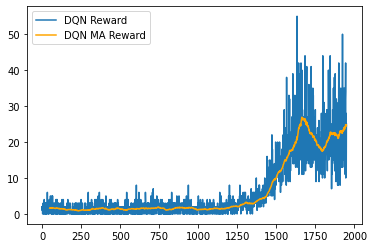

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

data = {'Reward':  stats.episode_rewards}
df = pd.DataFrame (data)

rolling_mean = df.Reward.rolling(window=50).mean()

plt.plot(df.index, df.Reward, label='DQN Reward')
plt.plot(df.index, rolling_mean, label='DQN MA Reward', color='orange')
plt.legend(loc='upper left')
plt.show()
df.to_csv('output_DQN2.csv', index=False)  